## 1. 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import load_diabetes

import joblib
import pickle

# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("所有库导入成功！")

所有库导入成功！


## 2. 加载和准备数据

我们使用sklearn自带的糖尿病数据集进行演示。这个数据集包含442个样本，10个特征。

In [2]:
# 加载数据集
data = load_diabetes()

# 查看数据信息
print(f"特征数量: {data.data.shape[1]}")
print(f"样本数量: {data.data.shape[0]}")
print(f"\n特征名称: {data.feature_names}")
print(f"\n数据集描述:\n{data.DESCR}")

特征数量: 10
样本数量: 442

特征名称: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

数据集描述:
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycer

In [3]:
# 创建DataFrame，更容易处理
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("特征数据X的前5行:")
print(X.head())
print(f"\n目标变量y的前5个值: {y.head().values}")
print(f"\n数据统计信息:\n{X.describe()}")

特征数据X的前5行:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  

目标变量y的前5个值: [151.  75. 141. 206. 135.]

数据统计信息:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02 

In [4]:
# 将数据分为训练集和测试集
# test_size=0.2 表示20%作为测试集，80%作为训练集
# random_state=42 保证结果可复现
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"训练集大小: {X_train.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")
print(f"特征数量: {X_train.shape[1]}")

训练集大小: 353
测试集大小: 89
特征数量: 10


## 3. 创建和训练线性回归模型

In [5]:
# 创建线性回归模型对象
model = LinearRegression()

# 使用训练数据进行拟合
# fit方法会根据训练数据计算模型参数
model.fit(X_train, y_train)

print("模型训练完成！")
print(f"\n模型参数（系数）:")
for feature, coef in zip(data.feature_names, model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"\n截距（intercept）: {model.intercept_:.4f}")

模型训练完成！

模型参数（系数）:
  age: 37.9040
  sex: -241.9644
  bmi: 542.4288
  bp: 347.7038
  s1: -931.4888
  s2: 518.0623
  s3: 163.4200
  s4: 275.3179
  s5: 736.1989
  s6: 48.6707

截距（intercept）: 151.3456


### 了解线性回归模型

线性回归模型的数学形式为：

$$y = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n x_n$$

其中：
- $y$ 是预测值
- $x_1, x_2, ..., x_n$ 是输入特征
- $w_0$ 是截距（intercept）
- $w_1, w_2, ..., w_n$ 是各特征的系数（coef）

**关键点**：系数的大小和符号反映了该特征对目标变量的影响程度和方向。

## 4. 模型预测和评估

In [6]:
# 在训练集和测试集上进行预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"实际值 (前5个): {y_train[:5].values}")
print(f"预测值 (前5个): {y_train_pred[:5].round(2)}")

实际值 (前5个): [144. 150. 280. 125.  59.]
预测值 (前5个): [184.7  151.95 239.23 105.02  65.03]


In [7]:
# 评估指标计算
# 1. R² 分数（决定系数）：衡量模型解释目标变量变异的程度
#    范围是 0-1，越接近1越好，表示模型拟合度越高
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 2. MSE（均方误差）：预测误差的平均平方
#    值越小越好
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 3. RMSE（均方根误差）：MSE的平方根
#    与原始数据同单位，更容易理解
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# 4. MAE（平均绝对误差）：预测误差的绝对值平均
#    对异常值不敏感
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# 打印评估结果
print("="*50)
print("模型评估指标")
print("="*50)
print(f"\n训练集性能:")
print(f"  R² 分数: {train_r2:.4f}")
print(f"  MSE:    {train_mse:.4f}")
print(f"  RMSE:   {train_rmse:.4f}")
print(f"  MAE:    {train_mae:.4f}")

print(f"\n测试集性能:")
print(f"  R² 分数: {test_r2:.4f}")
print(f"  MSE:    {test_mse:.4f}")
print(f"  RMSE:   {test_rmse:.4f}")
print(f"  MAE:    {test_mae:.4f}")

# 检查过拟合
print(f"\n拟合状态分析:")
print(f"  训练集R²: {train_r2:.4f}")
print(f"  测试集R²: {test_r2:.4f}")
if test_r2 < train_r2 - 0.1:
    print(f"  ⚠️  检测到可能的过拟合（差异 > 0.1）")
else:
    print(f"  ✓ 模型泛化能力良好")

模型评估指标

训练集性能:
  R² 分数: 0.5279
  MSE:    2868.5497
  RMSE:   53.5588
  MAE:    43.4835

测试集性能:
  R² 分数: 0.4526
  MSE:    2900.1936
  RMSE:   53.8534
  MAE:    42.7941

拟合状态分析:
  训练集R²: 0.5279
  测试集R²: 0.4526
  ✓ 模型泛化能力良好


### 评估指标说明表

| 指标 | 范围 | 含义 | MLOps应用 |
|------|------|------|----------|
| R² | [0, 1] | 解释的方差比例，越接近1越好 | 整体模型性能评估 |
| MSE | ≥0 | 误差平方和的平均，放大大误差 | 对大偏差敏感 |
| RMSE | ≥0 | MSE的平方根，与原数据同单位 | **推荐用于生产环境监控** |
| MAE | ≥0 | 误差绝对值的平均，稳健 | 对异常值不敏感 |

**MLOps建议**：
- 优先关注测试集性能（代表真实环境）
- 用RMSE作为生产监控的主要指标
- 建立告警阈值：如果RMSE超过某个值，自动重训练

## 5. 可视化结果

C:\Users\weiru\AppData\Local\Temp\ipykernel_27900\1074053783.py:38: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
d:\conda\envs\hq311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


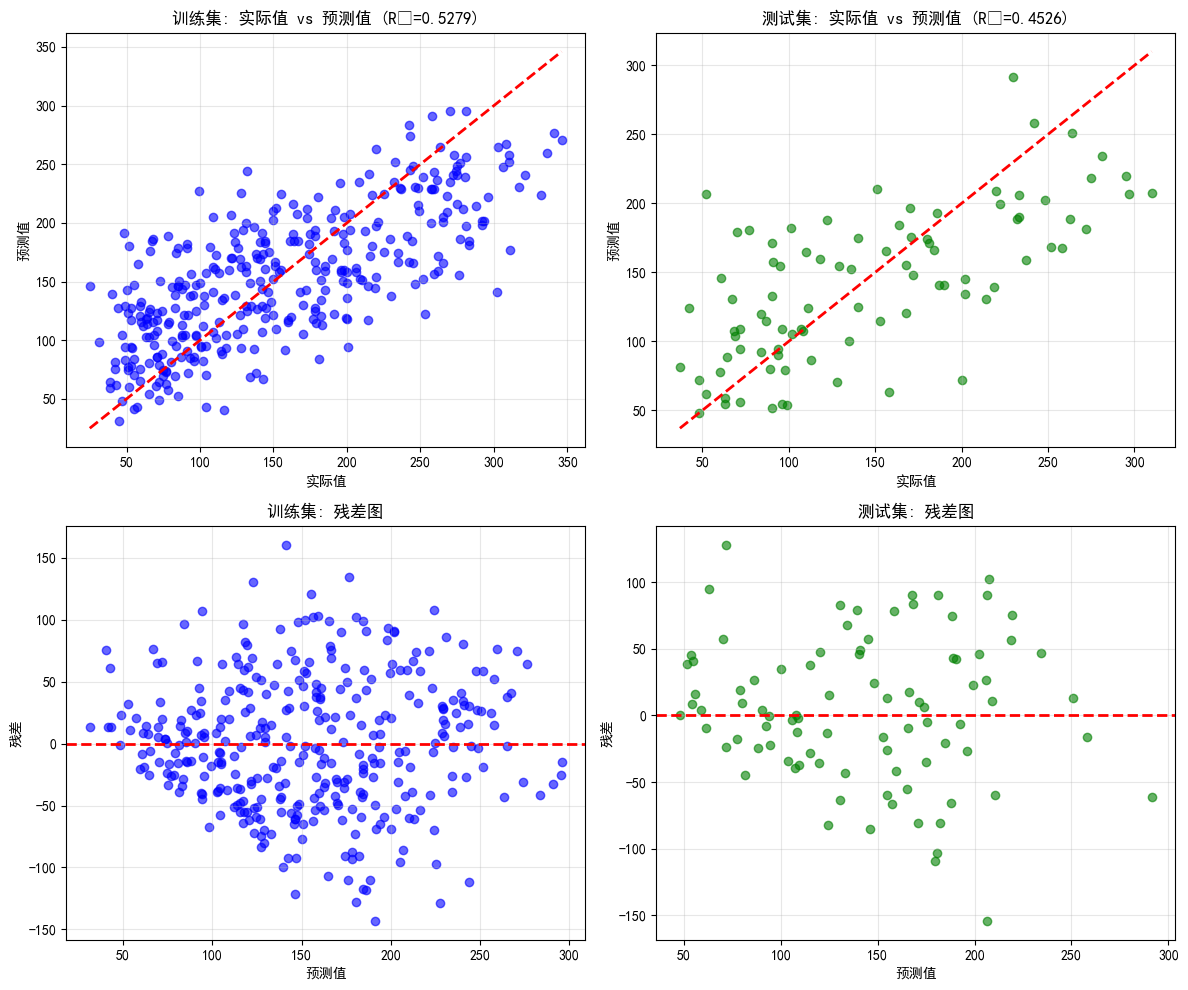

可视化完成！

残差分析:
  训练集残差均值: -0.0000
  训练集残差标准差: 53.6349
  测试集残差均值: 3.9128
  测试集残差标准差: 54.0154


In [8]:
# 创建可视化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 实际值 vs 预测值（训练集）
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('实际值')
axes[0, 0].set_ylabel('预测值')
axes[0, 0].set_title(f'训练集: 实际值 vs 预测值 (R²={train_r2:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. 实际值 vs 预测值（测试集）
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('实际值')
axes[0, 1].set_ylabel('预测值')
axes[0, 1].set_title(f'测试集: 实际值 vs 预测值 (R²={test_r2:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. 残差分布（训练集）
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('预测值')
axes[1, 0].set_ylabel('残差')
axes[1, 0].set_title('训练集: 残差图')
axes[1, 0].grid(True, alpha=0.3)

# 4. 残差分布（测试集）
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('预测值')
axes[1, 1].set_ylabel('残差')
axes[1, 1].set_title('测试集: 残差图')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("可视化完成！")
print(f"\n残差分析:")
print(f"  训练集残差均值: {train_residuals.mean():.4f}")
print(f"  训练集残差标准差: {train_residuals.std():.4f}")
print(f"  测试集残差均值: {test_residuals.mean():.4f}")
print(f"  测试集残差标准差: {test_residuals.std():.4f}")

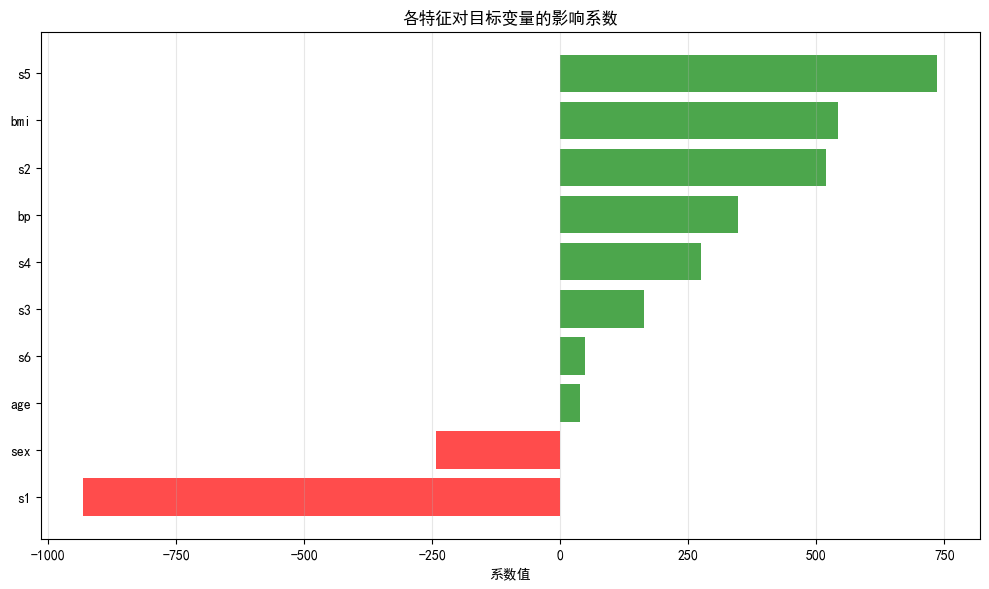

系数解释：
- 正系数（绿色）：特征值增加会增加目标变量
- 负系数（红色）：特征值增加会减少目标变量
- 系数绝对值越大，该特征的影响越大


In [9]:
# 特征系数可视化
coef_df = pd.DataFrame({
    '特征': data.feature_names,
    '系数': model.coef_
}).sort_values('系数')

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in coef_df['系数']]
plt.barh(coef_df['特征'], coef_df['系数'], color=colors, alpha=0.7)
plt.xlabel('系数值')
plt.title('各特征对目标变量的影响系数')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("系数解释：")
print("- 正系数（绿色）：特征值增加会增加目标变量")
print("- 负系数（红色）：特征值增加会减少目标变量")
print("- 系数绝对值越大，该特征的影响越大")

## 6. 模型持久化和部署（MLOps核心）

In [10]:
# 方案1：使用joblib保存模型（推荐用于sklearn）
# joblib性能更好，更适合大型模型

model_path_joblib = 'linear_regression_model.joblib'
joblib.dump(model, model_path_joblib)
print(f"✓ 模型已使用joblib保存到: {model_path_joblib}")

# 方案2：使用pickle保存模型
# pickle是标准库，更易于部署
model_path_pickle = 'linear_regression_model.pkl'
with open(model_path_pickle, 'wb') as f:
    pickle.dump(model, f)
print(f"✓ 模型已使用pickle保存到: {model_path_pickle}")

# 检查文件大小
import os
joblib_size = os.path.getsize(model_path_joblib)
pickle_size = os.path.getsize(model_path_pickle)
print(f"\n文件大小对比:")
print(f"  joblib: {joblib_size} 字节")
print(f"  pickle: {pickle_size} 字节")

✓ 模型已使用joblib保存到: linear_regression_model.joblib
✓ 模型已使用pickle保存到: linear_regression_model.pkl

文件大小对比:
  joblib: 1017 字节
  pickle: 719 字节


In [11]:
# 模型加载和使用
# 这展示了生产环境中如何使用保存的模型

# 方案1：加载joblib模型
loaded_model_joblib = joblib.load(model_path_joblib)
print("✓ joblib模型加载成功")

# 方案2：加载pickle模型
with open(model_path_pickle, 'rb') as f:
    loaded_model_pickle = pickle.load(f)
print("✓ pickle模型加载成功")

# 使用加载的模型进行预测
test_sample = X_test.iloc[0:1]  # 取第一个测试样本
prediction = loaded_model_joblib.predict(test_sample)

print(f"\n测试预测:")
print(f"  输入特征: {test_sample.values[0][:3]}... (仅显示前3个)")
print(f"  预测值: {prediction[0]:.2f}")
print(f"  实际值: {y_test.iloc[0]:.2f}")
print(f"  误差: {abs(prediction[0] - y_test.iloc[0]):.2f}")

✓ joblib模型加载成功
✓ pickle模型加载成功

测试预测:
  输入特征: [ 0.04534098 -0.04464164 -0.00620595]... (仅显示前3个)
  预测值: 139.55
  实际值: 219.00
  误差: 79.45


## 7. MLOps最佳实践

In [12]:
# 保存模型元数据，便于追踪和部署
import json
from datetime import datetime

metadata = {
    '模型名称': 'LinearRegression_Diabetes',
    '模型版本': '1.0.0',
    '训练时间': datetime.now().isoformat(),
    '训练样本数': X_train.shape[0],
    '测试样本数': X_test.shape[0],
    '特征数量': X_train.shape[1],
    '特征名称': data.feature_names.tolist(),
    '训练集R²': float(train_r2),
    '测试集R²': float(test_r2),
    '训练集RMSE': float(train_rmse),
    '测试集RMSE': float(test_rmse),
    '性能评估': {
        '训练集': {
            'R²': float(train_r2),
            'RMSE': float(train_rmse),
            'MAE': float(train_mae)
        },
        '测试集': {
            'R²': float(test_r2),
            'RMSE': float(test_rmse),
            'MAE': float(test_mae)
        }
    },
    '模型参数': {
        'intercept': float(model.intercept_),
        'coefficients': {feature: float(coef) for feature, coef in zip(data.feature_names, model.coef_)}
    },
    '是否可投入生产': test_r2 > 0.4  # 自定义阈值
}

# 保存元数据
metadata_path = 'model_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✓ 元数据已保存到: {metadata_path}")
print(f"\n模型元数据概览:")
print(f"  模型版本: {metadata['模型版本']}")
print(f"  测试集R²: {metadata['测试集R²']:.4f}")
print(f"  测试集RMSE: {metadata['测试集RMSE']:.4f}")
print(f"  是否可投入生产: {metadata['是否可投入生产']}")

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
# 创建推理函数，便于生产部署
class LinearRegressionPredictor:
    """
    线性回归预测器 - 用于生产环境
    """
    
    def __init__(self, model_path):
        """初始化，加载模型"""
        self.model = joblib.load(model_path)
        self.model_path = model_path
        
    def predict_single(self, features_dict):
        """
        单个预测
        Args:
            features_dict: 特征字典，例如 {'age': 30, 'bmi': 25, ...}
        Returns:
            预测值
        """
        # 这里需要与训练时的特征顺序一致
        df = pd.DataFrame([features_dict])
        return self.model.predict(df)[0]
    
    def predict_batch(self, features_df):
        """
        批量预测
        Args:
            features_df: 特征DataFrame
        Returns:
            预测结果数组
        """
        return self.model.predict(features_df)
    
    def get_model_info(self):
        """
        获取模型信息
        """
        return {
            'model_path': self.model_path,
            'coefficients': dict(zip(data.feature_names, self.model.coef_)),
            'intercept': self.model.intercept_
        }

# 使用预测器
predictor = LinearRegressionPredictor(model_path_joblib)

# 单个预测示例
test_features = X_test.iloc[0]
prediction = predictor.predict_single(test_features.to_dict())
print(f"单个预测: {prediction:.2f}")

# 批量预测
batch_predictions = predictor.predict_batch(X_test.head(5))
print(f"\n批量预测 (前5个): {batch_predictions.round(2)}")

# 获取模型信息
model_info = predictor.get_model_info()
print(f"\n模型信息已获取")

## 8. 总结和MLOps检查清单

### sklearn线性回归工作流总结

```
┌─────────────────────────────────────────────────────────┐
│           sklearn 线性回归完整工作流                      │
├─────────────────────────────────────────────────────────┤
│                                                           │
│  1. 数据准备                                             │
│     ├─ 加载数据 (load_diabetes, read_csv 等)            │
│     ├─ 数据探索 (head, describe, shape)                  │
│     └─ 数据分割 (train_test_split)                      │
│                                                           │
│  2. 模型创建与训练                                       │
│     ├─ 创建模型 (LinearRegression())                     │
│     └─ 拟合训练 (model.fit(X_train, y_train))           │
│                                                           │
│  3. 模型预测                                             │
│     ├─ 训练集预测 (model.predict(X_train))              │
│     └─ 测试集预测 (model.predict(X_test))               │
│                                                           │
│  4. 模型评估                                             │
│     ├─ R² 分数 (r2_score)                               │
│     ├─ RMSE (mean_squared_error)                        │
│     └─ MAE (mean_absolute_error)                        │
│                                                           │
│  5. 结果可视化                                           │
│     ├─ 预测 vs 实际散点图                                │
│     ├─ 残差图                                            │
│     └─ 特征系数柱状图                                    │
│                                                           │
│  6. 模型部署                                             │
│     ├─ 模型保存 (joblib.dump)                            │
│     ├─ 元数据保存 (json)                                 │
│     ├─ 模型加载 (joblib.load)                            │
│     └─ 推理函数封装 (Predictor 类)                      │
│                                                           │
└─────────────────────────────────────────────────────────┘
```

### MLOps检查清单

#### 数据管理
- [ ] 数据来源明确，版本可追踪
- [ ] 数据分割使用固定的random_state保证可复现性
- [ ] 训练/测试集严格分离，防止数据泄露

#### 模型开发
- [ ] 清晰的特征列表和说明
- [ ] 记录模型超参数（虽然LinearRegression没有太多）
- [ ] 保存完整的模型artifact

#### 性能监控
- [ ] **R² > 0.4** - 模型整体质量
- [ ] **RMSE** - 生产监控的主要指标
- [ ] **训练集 vs 测试集性能差异** - 检测过拟合
- [ ] **MAE** - 对特定应用场景的评估

#### 版本管理
- [ ] 模型版本号 (semantic versioning)
- [ ] 训练时间和数据集版本
- [ ] 性能指标历史记录
- [ ] 模型元数据完整性

#### 部署和推理
- [ ] 模型序列化（joblib/pickle）
- [ ] 推理函数/类的单元测试
- [ ] 错误处理和日志记录
- [ ] 性能基准测试（推理延迟）

#### 持续改进
- [ ] 监控生产环境的预测性能
- [ ] 定期重新训练流程
- [ ] A/B 测试框架
- [ ] 数据漂移检测

In [ ]:
# MLOps检查清单验证
print("="*60)
print("MLOps准备就绪检查")
print("="*60)

checks = {
    "模型训练完成": True,
    "测试集评估完成": test_r2 is not None,
    "模型已保存 (joblib)": os.path.exists(model_path_joblib),
    "模型已保存 (pickle)": os.path.exists(model_path_pickle),
    "元数据已保存": os.path.exists(metadata_path),
    "推理函数已编写": 'predictor' in locals(),
    "测试集R² > 0.4": test_r2 > 0.4,
}

for item, status in checks.items():
    status_icon = "✓" if status else "✗"
    print(f"{status_icon} {item}")

print("\n" + "="*60)
all_pass = all(checks.values())
if all_pass:
    print("✓ 所有检查通过！模型已准备好部署到生产环境")
else:
    print("⚠️  存在未通过的检查项，请修复")
print("="*60)

## 9. 常见问题和解决方案

### Q1: 如何处理特征缩放？

虽然线性回归对特征缩放不敏感，但为了统一性和最佳实践，建议使用 `StandardScaler` 或 `MinMaxScaler`：

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # 重要：不要fit测试数据
```

### Q2: 模型性能差怎么办？

1. **数据质量**：检查是否有异常值或缺失值
2. **特征工程**：添加多项式特征或交互项
3. **特征选择**：移除不相关的特征
4. **尝试其他模型**：Ridge回归、Lasso回归等

### Q3: 如何部署到生产环境？

推荐方案：
- **Flask/FastAPI**：创建REST API
- **Docker容器化**：便于部署和扩展
- **云平台**：AWS SageMaker、Google Vertex AI、Azure ML
- **模型注册表**：MLflow、Weights & Biases等

### Q4: 如何监控模型漂移？

在生产环境中定期检查：
- 输入特征分布是否改变
- 预测误差是否增加
- 推理延迟是否升高

当指标超过阈值时，自动触发模型重训练。

## 10. 进阶资源

### 相关算法和扩展

1. **Ridge 回归** - 添加L2正则化，防止过拟合
   ```python
   from sklearn.linear_model import Ridge
   model = Ridge(alpha=1.0)
   ```

2. **Lasso 回归** - 添加L1正则化，进行特征选择
   ```python
   from sklearn.linear_model import Lasso
   model = Lasso(alpha=0.1)
   ```

3. **多项式回归** - 处理非线性关系
   ```python
   from sklearn.preprocessing import PolynomialFeatures
   poly = PolynomialFeatures(degree=2)
   X_poly = poly.fit_transform(X)
   ```

### MLOps学习路线
- 第1步：掌握基本算法（✓ 完成）
- 第2步：模型评估和验证
- 第3步：特征工程
- 第4步：模型部署（Flask/Docker）
- 第5步：模型监控和重训练
- 第6步：CI/CD流程
- 第7步：云平台集成

### 推荐工具
| 工具 | 用途 | 说明 |
|-----|------|------|
| MLflow | 实验管理 | 追踪参数、指标、模型 |
| DVC | 数据版本 | 管理数据和模型版本 |
| Docker | 容器化 | 确保生产环境一致性 |
| Airflow | 工作流 | 自动化训练和部署 |
| Prometheus | 监控 | 收集和展示性能指标 |